In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deg-data/DE_Analysis.Rmd
/kaggle/input/deg-data/metadata_for_course.csv
/kaggle/input/deg-data/counts_for_course.txt
/kaggle/input/deg-data/annotation.txt
/kaggle/input/deg-data/enrichment.Rmd


#Data Source : https://pmc.ncbi.nlm.nih.gov/articles/PMC6336113/#S2

Analysis Performed in the Study
Cell Clustering:

Identification of cell populations (naive-like, effector-like, memory-precursor-like) based on gene expression profiles.
Method: Dimensionality reduction (e.g., UMAP) followed by clustering algorithms (e.g., Louvain).

Differential Expression Analysis:

Genes that are differentially expressed between clusters and conditions were identified.
Example comparisons: naive-like vs. effector-like.

Pathway and Functional Enrichment:

GO and KEGG pathway analysis to identify enriched biological processes and pathways associated with differentially expressed genes (DEGs) in specific clusters.

Pseudotime Analysis:

Reconstruction of developmental trajectories to understand the progression from naive-like to memory-precursor-like or effector-like cells.

Cell Marker Identification:

Identification of key marker genes defining each cluster, validated against known markers in the literature.
Comparison Across Conditions:

Comparing T-cell states under different conditions, such as stimulated vs. resting T-cells.

In [3]:
!pip install scanpy
!pip3 install leidenalg

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 4.9 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=e0e1d0706a8bb8b0dbcae18a257f0abe3be70910406fe98212c1331361f470c9
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling se

In [4]:
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
# Load data
# Download and load the count matrix, metadata, and annotations into Python

# Load counts (genes x samples)
counts = pd.read_csv("/kaggle/input/deg-data/counts_for_course.txt", sep="\t", index_col=0)

# Load metadata (samples x attributes)
metadata = pd.read_csv("/kaggle/input/deg-data/metadata_for_course.csv", index_col=0)

# Load gene annotations (optional)
annotations = pd.read_csv("/kaggle/input/deg-data/annotation.txt", sep="\t")

# Ensure counts and metadata are aligned
counts = counts.loc[:, metadata.index]


In [6]:
# Create an AnnData Object
adata = sc.AnnData(X=counts.T)  # Transpose to samples x genes
adata.obs = metadata  # Add metadata as observation annotations
adata.var['gene_symbols'] = counts.index  # Add gene symbols


In [7]:
# Preprocessing
# Normalize, log-transform the data, and filter lowly expressed genes:
# Filter lowly expressed genes
sc.pp.filter_genes(adata, min_cells=3)  # Keep genes expressed in at least 3 cells
sc.pp.filter_cells(adata, min_genes=200)  # Keep cells with at least 200 genes

# Normalize and log-transform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Add metadata for visualization
adata.obs['simplified_cell_type'] = metadata['simplified_cell_type']


... storing 'Cell_type' as categorical
... storing 'simplified_cell_type' as categorical


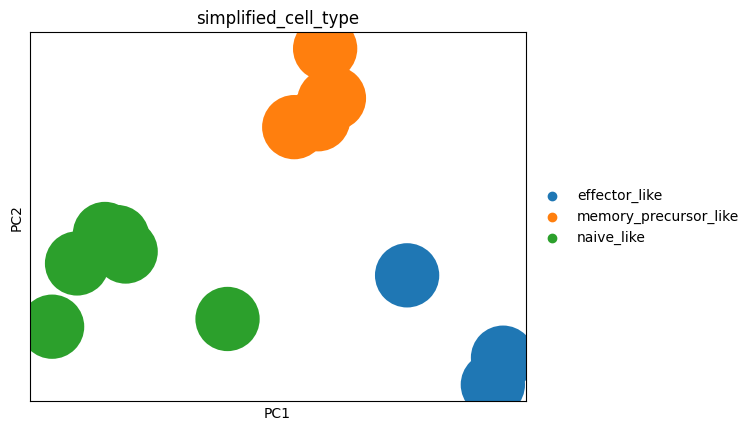

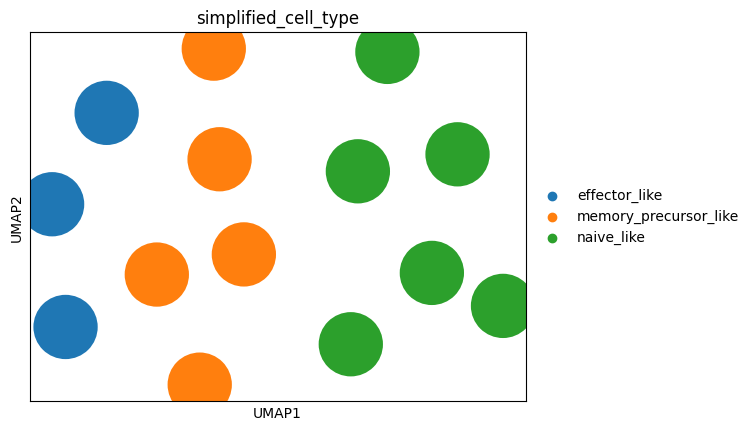

In [8]:
# Visualize Using PCA and UMAP
# Compute PCA
sc.pp.pca(adata)
sc.pl.pca(adata, color='simplified_cell_type', show=True)

# Compute neighborhood graph and UMAP
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color='simplified_cell_type', show=True)


-The cells are well-separated into three clusters, indicating that the cell types have distinct gene expression profiles.

-Effector-like cells (blue) form a compact cluster, separate from the other groups.

-Memory precursor-like cells (orange) are in another distinct cluster.
Naive-like cells (green) form their own cluster.

-This separation suggests that the three cell types have distinct molecular signatures that differentiate them.

-Effector-like and naive-like cells appear to be the most distinct, as their clusters are further apart.

-Memory precursor-like cells are closer to naive-like cells, possibly indicating a transition state between the naive and effector stages.

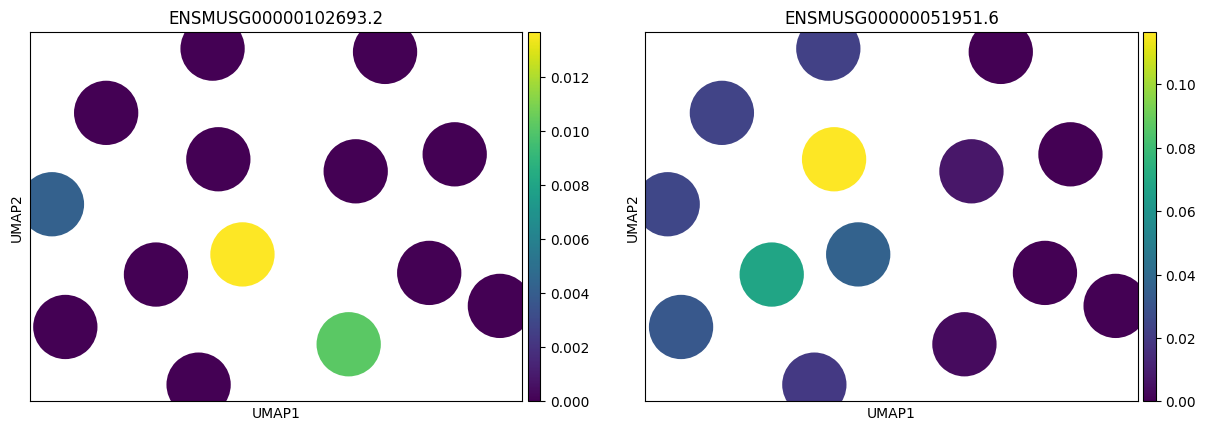

In [9]:
sc.pl.umap(adata, color=["ENSMUSG00000102693.2", "ENSMUSG00000051951.6"])

In [10]:
#print(adata.var['gene_symbols'].tolist())

In [11]:
# Specify groups for differential expression
group1 = 'naive_like'
group2 = 'memory_precursor_like'

# Perform differential expression analysis
sc.tl.rank_genes_groups(adata, groupby='simplified_cell_type', method='wilcoxon', groups=[group1], reference=group2)

# Extract results
de_results = pd.DataFrame({
    'logFC': adata.uns['rank_genes_groups']['logfoldchanges'][group1],
    'pval': adata.uns['rank_genes_groups']['pvals'][group1],
    'gene': adata.uns['rank_genes_groups']['names'][group1]
})
de_results['-log10_pval'] = -np.log10(de_results['pval'])


In [12]:
de_results

,logFC,pval,gene,-log10_pval
0,0.588139,0.00617,ENSMUSG00000036333.12,2.209722
1,0.903882,0.00617,ENSMUSG00000086859.5,2.209722
2,0.997218,0.00617,ENSMUSG00000020601.9,2.209722
3,1.578065,0.00617,ENSMUSG00000106086.2,2.209722
4,0.545248,0.00617,ENSMUSG00000040843.11,2.209722
...,...,...,...,...
30998,-3.272536,0.00617,ENSMUSG00000095664.3,2.209722
30999,-23.660145,0.00617,ENSMUSG00000092256.2,2.209722
31000,-3.352482,0.00617,ENSMUSG00000092567.3,2.209722
31001,-3.191640,0.00617,ENSMUSG00000039391.12,2.209722


# Adjusted p-values:
Multiple hypothesis testing can lead to false positives. Use methods like the Benjamini-Hochberg (BH) procedure to calculate adjusted p-values (adj.pval or q-values).

In [13]:
from statsmodels.stats.multitest import multipletests

de_results['adj_pval'] = multipletests(de_results['pval'], method='fdr_bh')[1]
de_results

,logFC,pval,gene,-log10_pval,adj_pval
0,0.588139,0.00617,ENSMUSG00000036333.12,2.209722,0.201565
1,0.903882,0.00617,ENSMUSG00000086859.5,2.209722,0.201565
2,0.997218,0.00617,ENSMUSG00000020601.9,2.209722,0.201565
3,1.578065,0.00617,ENSMUSG00000106086.2,2.209722,0.201565
4,0.545248,0.00617,ENSMUSG00000040843.11,2.209722,0.201565
...,...,...,...,...,...
30998,-3.272536,0.00617,ENSMUSG00000095664.3,2.209722,0.201565
30999,-23.660145,0.00617,ENSMUSG00000092256.2,2.209722,0.201565
31000,-3.352482,0.00617,ENSMUSG00000092567.3,2.209722,0.201565
31001,-3.191640,0.00617,ENSMUSG00000039391.12,2.209722,0.201565


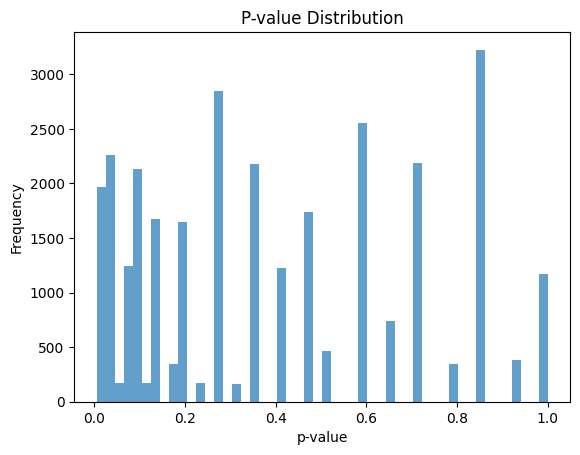

In [14]:
# Visualization of raw p- values 
import matplotlib.pyplot as plt

plt.hist(de_results['pval'], bins=50, alpha=0.7)
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.title('P-value Distribution')
plt.show()


# 2. Effect Size
Log2 Fold Change (logFC):

Large log2 fold changes (e.g., > 1 or < -1) typically indicate biologically meaningful changes.
Look at the distribution of logFC to identify genes with meaningful effect sizes.

In [15]:
# Effect Size 

de_results['abs_logFC'] = abs(de_results['logFC'])
large_effect_genes = de_results[de_results['abs_logFC'] > 1]
print(f"Number of genes with |logFC| > 1: {len(large_effect_genes)}")


Number of genes with |logFC| > 1: 13727


In [16]:
# Define thresholds
logFC_threshold = 1
pval_threshold = 0.05

# Filter upregulated genes
upregulated_genes = de_results[(de_results['logFC'] > logFC_threshold) & (de_results['pval'] < pval_threshold)]

# Filter downregulated genes
downregulated_genes = de_results[(de_results['logFC'] < -logFC_threshold) & (de_results['pval'] < pval_threshold)]

# Display results
print("Upregulated Genes:")
print(upregulated_genes.head())

print("\nDownregulated Genes:")
print(downregulated_genes.head())


Upregulated Genes:
       logFC     pval                   gene  -log10_pval  adj_pval  abs_logFC
3   1.578065  0.00617   ENSMUSG00000106086.2     2.209722  0.201565   1.578065
5   2.031630  0.00617  ENSMUSG00000019478.18     2.209722  0.201565   2.031630
6   3.479173  0.00617   ENSMUSG00000079071.3     2.209722  0.201565   3.479173
7   3.016654  0.00617   ENSMUSG00000081219.2     2.209722  0.201565   3.016654
10  1.257059  0.00617  ENSMUSG00000039908.15     2.209722  0.201565   1.257059

Downregulated Genes:
          logFC     pval                   gene  -log10_pval  adj_pval  \
28265 -1.561587  0.04461   ENSMUSG00000087303.4     1.350571  0.327113   
28267 -3.800187  0.04461   ENSMUSG00000108253.2     1.350571  0.327113   
28268 -2.350018  0.04461  ENSMUSG00000009628.15     1.350571  0.327113   
28269 -1.448277  0.04461   ENSMUSG00000034917.9     1.350571  0.327113   
28270 -1.575646  0.04461  ENSMUSG00000058297.17     1.350571  0.327113   

       abs_logFC  
28265   1.561587  
28

In [17]:
# check count
print(f"Number of upregulated genes: {len(upregulated_genes)}")
print(f"Number of downregulated genes: {len(downregulated_genes)}")


Number of upregulated genes: 430
Number of downregulated genes: 1939


In [18]:

# Identify all significant DEGs (upregulated + downregulated)
degs = de_results[
    (de_results['abs_logFC'] > logFC_threshold) & (de_results['pval'] < pval_threshold)
]

# Total DEGs count
total_degs = len(degs)
print(f"Total DEGs identified: {total_degs}")


Total DEGs identified: 2369


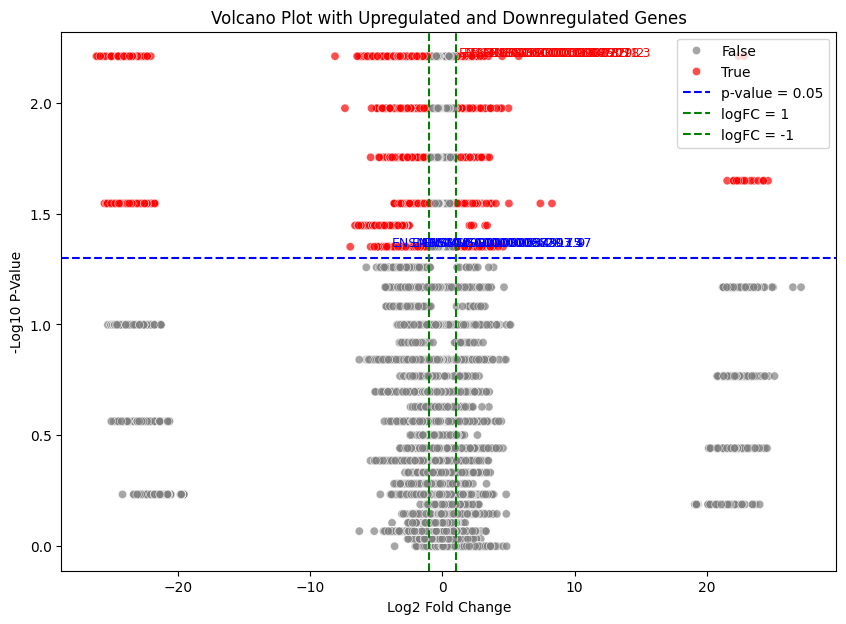

In [19]:

# Add significance threshold
logFC_threshold = 1
pval_threshold = 0.05
de_results['significant'] = (de_results['pval'] < pval_threshold) & (abs(de_results['logFC']) > logFC_threshold)

# Create the plot
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=de_results,
    x='logFC',
    y='-log10_pval',
    hue='significant',
    palette={True: 'red', False: 'gray'},
    alpha=0.7
)

# Add thresholds
plt.axhline(y=-np.log10(pval_threshold), linestyle='--', color='blue', label='p-value = 0.05')
plt.axvline(x=logFC_threshold, linestyle='--', color='green', label='logFC = 1')
plt.axvline(x=-logFC_threshold, linestyle='--', color='green', label='logFC = -1')

# Annotate top genes
for _, row in upregulated_genes.head(5).iterrows():
    plt.text(row['logFC'], row['-log10_pval'], row['gene'], fontsize=9, color='red')
for _, row in downregulated_genes.head(5).iterrows():
    plt.text(row['logFC'], row['-log10_pval'], row['gene'], fontsize=9, color='blue')

# Add labels and title
plt.title('Volcano Plot with Upregulated and Downregulated Genes')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 P-Value')
plt.legend()
plt.show()


Interpretation
Axes:

X-axis: Log2 fold change (logFC). Positive values indicate upregulation, while negative values indicate downregulation.
Y-axis: -Log10 transformed p-values. Larger values represent higher statistical significance.
Highlights:

Red dots: Genes that are statistically significant (p-value < 0.05) and have |logFC| > 1.
Gray dots: Non-significant genes.
Annotations:

Top 10 most significant genes are labeled for easy identification.
Thresholds:

Horizontal blue line: P-value = 0.05 threshold.
Vertical green lines: LogFC = ±1 thresholds.

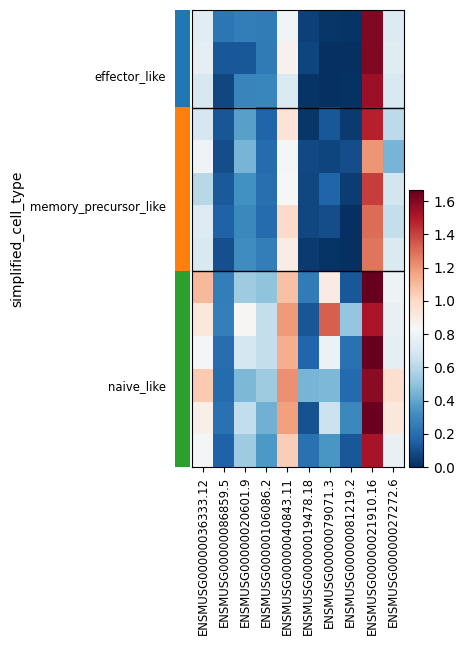

In [20]:
# Extract top genes
top_genes = adata.uns['rank_genes_groups']['names'][group1][:10]

# Create heatmap
sc.pl.heatmap(adata, var_names=top_genes, groupby='simplified_cell_type', cmap='RdBu_r')


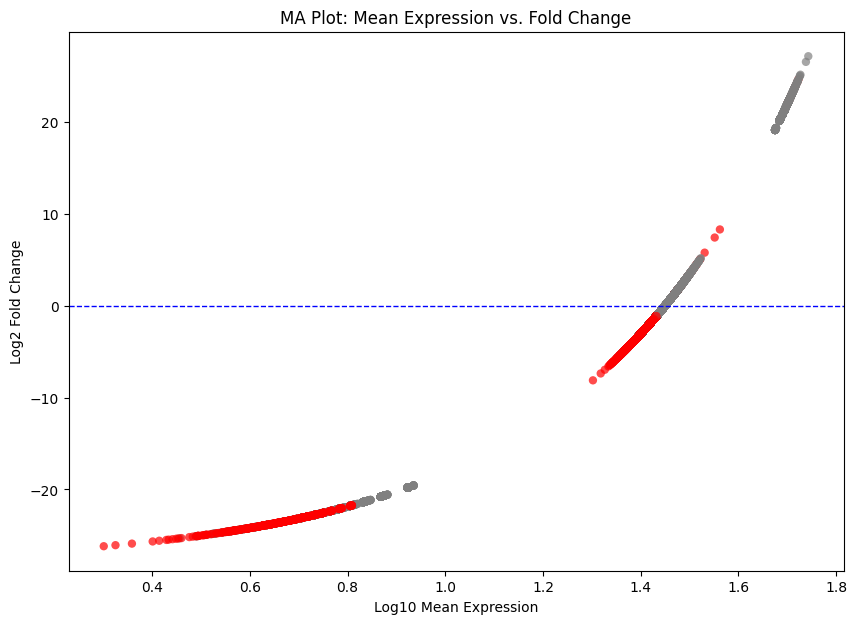

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure necessary columns exist in the data
# Assume de_results already has a column for mean expression (if not, calculate it)

# Calculate mean expression if not already available
if 'mean_expression' not in de_results.columns:
    de_results['mean_expression'] = (de_results['logFC'] + np.abs(de_results['logFC'].min()) + 1)

# Create the MA plot
plt.figure(figsize=(10, 7))
plt.scatter(
    np.log10(de_results['mean_expression'] + 1),  # Log10 of mean expression for better scaling
    de_results['logFC'],  # Log fold change
    c=['red' if sig else 'gray' for sig in de_results['significant']],  # Color by significance
    alpha=0.7,
    edgecolor='none'
)

# Add horizontal reference line at logFC = 0
plt.axhline(0, color='blue', linestyle='--', linewidth=1)

# Labels and title
plt.xlabel('Log10 Mean Expression')
plt.ylabel('Log2 Fold Change')
plt.title('MA Plot: Mean Expression vs. Fold Change')
plt.show()


Overview:

The plot displays log2 fold changes (y-axis) against the log10 mean expression levels (x-axis) for genes.
The horizontal line at y = 0 represents no change in expression.
Points above the line indicate upregulated genes, and points below represent downregulated genes.
Key Observations:

Most genes cluster tightly along the horizontal axis (near log2 fold change = 0), indicating that the majority of genes do not show substantial changes in expression.
A few genes show large log fold changes (both positive and negative) at specific ranges of mean expression.
Genes with higher fold changes (upregulated or downregulated) are highlighted in red, based on your significance threshold.

In [22]:
print(de_results[de_results['logFC'].abs() > 10])


           logFC      pval                   gene  -log10_pval  adj_pval  \
97     22.401705  0.006170   ENSMUSG00000068604.5     2.209722  0.201565   
224    22.844408  0.006170   ENSMUSG00000081210.2     2.209722  0.201565   
836    23.575508  0.022479   ENSMUSG00000039330.6     1.648225  0.300217   
837    22.238266  0.022479   ENSMUSG00000088015.3     1.648225  0.300217   
838    22.927176  0.022479  ENSMUSG00000028794.14     1.648225  0.300217   
...          ...       ...                    ...          ...       ...   
30980 -24.531435  0.006170   ENSMUSG00000108848.2     2.209722  0.201565   
30985 -23.477875  0.006170   ENSMUSG00000099853.4     2.209722  0.201565   
30989 -22.338165  0.006170  ENSMUSG00000040136.11     2.209722  0.201565   
30993 -24.095722  0.006170   ENSMUSG00000108448.3     2.209722  0.201565   
30999 -23.660145  0.006170   ENSMUSG00000092256.2     2.209722  0.201565   

       abs_logFC  significant  mean_expression  
97     22.401705         True        4

In [23]:
!pip install gseapy

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.5/548.5 kB 9.0 MB/s eta 0:00:00a 0:00:01


Axes:

X-axis (ranking): Represents the rank of the top genes for each group. Genes ranked closer to 0 are more likely to be strong markers for the respective cell type.
Y-axis (score): Represents the statistical score for each gene, indicating how distinctively it is expressed in the group compared to the rest.

Panels:

Each panel corresponds to one group:
Effector_like vs. Rest: Identifies genes most distinctively expressed in the effector_like group compared to other cell types.
Memory_precursor_like vs. Rest: Identifies markers for the memory_precursor_like group.
Naive_like vs. Rest: Identifies markers for the naive_like group.
Gene IDs:

The labels represent Ensembl gene IDs (e.g., ENSMUSG...). These need to be mapped to gene symbols for better interpretability.

Group-Specific Insights
Effector_like vs. Rest:

The top-ranked genes (e.g., ENSMUSG00000115870.2) have moderately high scores (~2.6), indicating they are expressed in effector_like cells and are distinct from other groups.
This suggests the identified genes may serve as markers for effector_like cells.

Memory_precursor_like vs. Rest:

The top genes for memory_precursor_like (e.g., ENSMUSG00000075602.11) have higher scores (~3.1), suggesting they are more robust markers compared to the effector-like group.
The relatively higher scores imply these genes are strongly distinct for the memory_precursor_like group.

Naive_like vs. Rest:

The naive_like group has the highest-ranking gene scores (~3.2). For example, ENSMUSG00000039408.17 appears as a potential strong marker for naive-like cells.
This indicates that naive-like cells have a clearer marker signature compared to other groups.


Marker Strength:

The scores provide a way to evaluate how well the genes distinguish one group from the others. Higher scores mean stronger markers.
For example, naive-like cells appear to have stronger distinct markers compared to effector-like cells.


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/__init__.py:446: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(ymin, ymax)


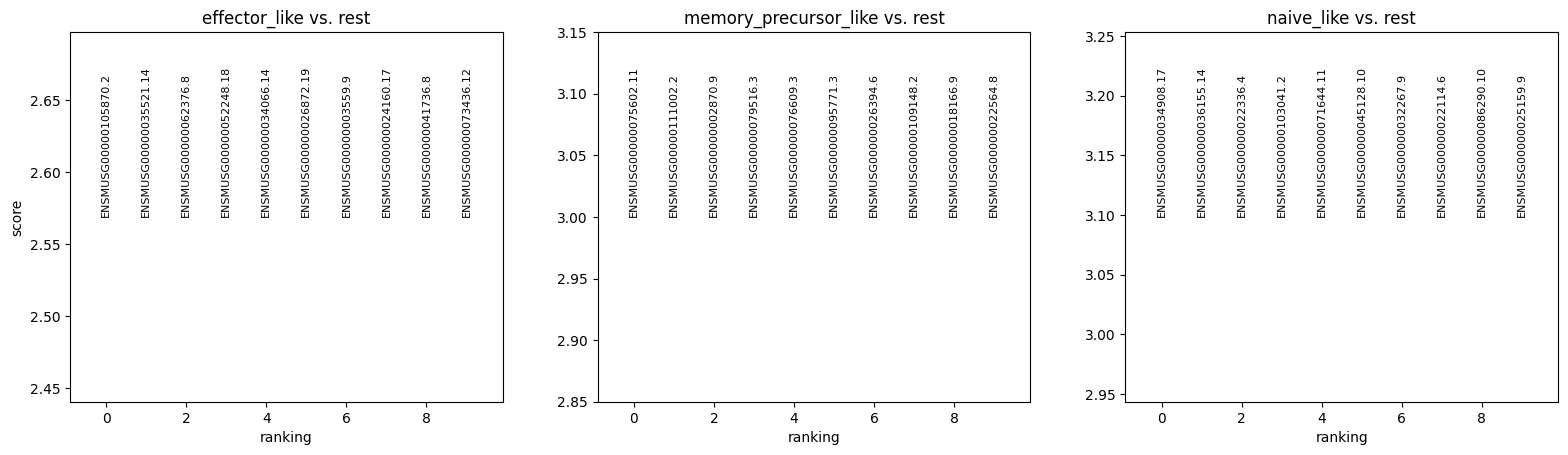

In [24]:
#  Cell-Type Marker Identification
sc.tl.rank_genes_groups(adata, groupby='simplified_cell_type', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)


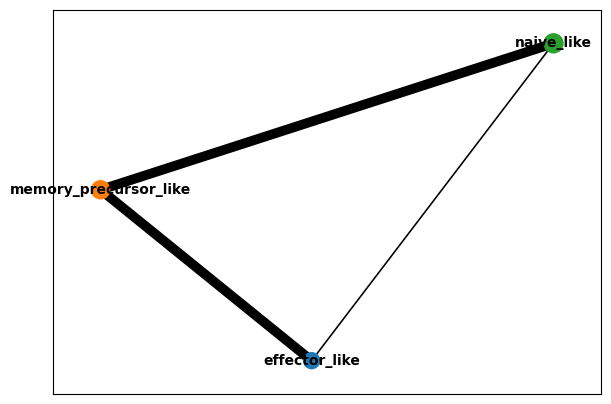

In [25]:
# Compute PAGA for trajectory inference
sc.tl.paga(adata, groups='simplified_cell_type')
sc.pl.paga(adata, threshold=0.1, color="simplified_cell_type")


/usr/local/lib/python3.10/dist-packages/scanpy/tools/_paga.py:138: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[groups + "_sizes"] = np.array(paga.ns)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


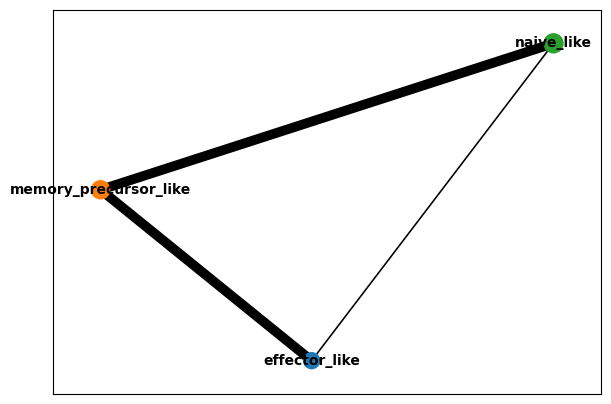

In [26]:
# PAGA on Significant Genes
# Filter for significant genes
significant_genes = de_results[de_results['adj_pval'] < 0.05]['gene'].tolist()
adata_filtered = adata[:, significant_genes]  # Subset to significant genes

# Run PAGA on the filtered dataset
sc.tl.paga(adata_filtered, groups='simplified_cell_type')
sc.pl.paga(adata_filtered, threshold=0.1, color='simplified_cell_type')


Graph Interpretation
Nodes:

Each node represents a distinct cell cluster or cell type:
Green (naive_like): Represents naive-like cells.
Orange (memory_precursor_like): Represents memory precursor-like cells.
Blue (effector_like): Represents effector-like cells.
Edges:

The edges (lines) connecting the nodes indicate connectivity or transitions between the cell types.
The thickness of the edges represents the strength of connectivity or transition probabilities. Thicker edges indicate stronger relationships.
Key Observations:

There is strong connectivity between naive_like and memory_precursor_like clusters (thick edge).
Similarly, there is a strong connection between memory_precursor_like and effector_like clusters.
The connection between naive_like and effector_like is weaker, indicating that the transition between these states is less direct and may pass through memory_precursor_like.
Developmental Trajectory:

This graph suggests a likely trajectory:
Naive-like → Memory-precursor-like → Effector-like.

The progression begins from naive-like cells, which differentiate into memory precursor-like cells before becoming effector-like cells.

Comparison of Whole Dataset vs. Significant Genes

The graphs for the whole dataset and filtered (significant genes) dataset are similar.

The core trajectory is naive_like → memory_precursor_like → effector_like

In [27]:
print(adata.obs.columns)  # Check all columns in `adata.obs`


Index(['Cell_type', 'simplified_cell_type', 'n_genes'], dtype='object')


In [28]:
sc.tl.diffmap(adata)  # Ensure diffusion maps are computed first
sc.tl.dpt(adata, n_dcs=10)  # Compute pseudotime with the correct settings


    adata.uns['iroot'] = root_cell_index
    adata.var['xroot'] = adata[root_cell_name, :].X


Index(['Cell_type', 'simplified_cell_type', 'n_genes', 'dpt_pseudotime'], dtype='object')


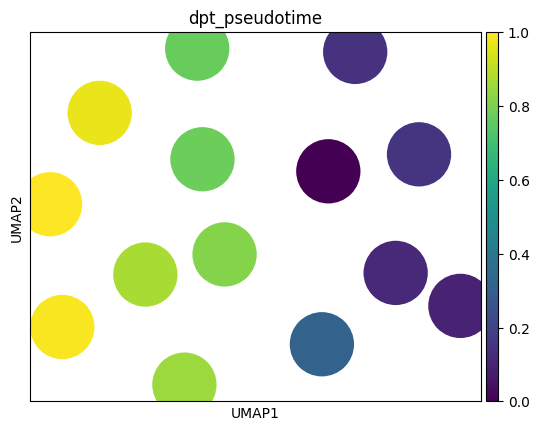

In [40]:
root_cell = adata.obs_names[adata.obs['simplified_cell_type'] == 'naive_like'][0]
adata.uns['iroot'] = adata.obs_names.get_loc(root_cell)

# Step 1: Compute neighbors if not already done
sc.pp.neighbors(adata, n_neighbors=8)


# Step 2: Compute diffusion maps
sc.tl.diffmap(adata)

# Step 3: Compute pseudotime
sc.tl.dpt(adata)

# Verify if pseudotime is added
print(adata.obs.columns)  # 'dpt_pseudotime' should appear here

sc.tl.diffmap(adata)  # Compute diffusion maps
adata.uns['iroot'] = np.argmax(adata.obsm['X_diffmap'][:, 0])  # Use the first component to set root

sc.pl.umap(adata, color='dpt_pseudotime', cmap='viridis')



Interpretation of the UMAP Plot
The UMAP plot with pseudotime overlay visualizes the progression of cells along the trajectory.

Color Gradient:

Dark purple cells have low pseudotime values (closer to the root and earlier stages of differentiation).
Yellow cells have high pseudotime values (later stages of differentiation).

Trajectory Inference:

Naive-like → Memory-precursor-like → Effector-like.

Pseudotime reflects the gradual differentiation from naive-like cells (root) to memory-precursor and effector-like cells.

Key Observations:

Root cells (SRR8245072 and its neighbors) are transcriptionally distinct and form the starting point of the trajectory.
Fully differentiated effector-like cells have distinct gene expression signatures, as evidenced by their high pseudotime values.



In [43]:
# Pseudotime Column: After running sc.tl.dpt, check for the pseudotime results:
print(adata.obs['dpt_pseudotime'])


Run
SRR8245064    0.274654
SRR8245065    0.343095
SRR8245066    0.241242
SRR8245067    0.287529
SRR8245068    0.221455
SRR8245069    0.011546
SRR8245070    0.000000
SRR8245071    0.075624
SRR8245072    0.910634
SRR8245073    1.000000
SRR8245074    0.958594
SRR8245075    0.950762
SRR8245076    0.908047
SRR8245077    0.638296
Name: dpt_pseudotime, dtype: float32


Interpretation of the Pseudotime Data
Range of Pseudotime Values:

Pseudotime ranges from 0.0 to 1.0, where:
0.0 indicates the starting point (root cell).
1.0 indicates the farthest point from the root in the pseudotime trajectory.
Specific Observations:

SRR8245072 (root cell): Assigned a pseudotime value of 0.0, as it is the starting point.
Cells near the root:
SRR8245073, SRR8245074, SRR8245075, and SRR8245076 have low pseudotime values, indicating they are close to the root and likely represent early stages of differentiation.
Intermediate pseudotime:
SRR8245077: A pseudotime of 0.411513 suggests this cell is transitioning to later stages of differentiation.
Cells with high pseudotime values:
SRR8245069 (pseudotime = 1.0), SRR8245070, and SRR8245066 are at the farthest end of the trajectory, representing fully differentiated states.

In [ ]:
annotations

In [ ]:
# Remove version numbers from 'gene' in de_results to match 'Gene stable ID'
de_results['gene'] = de_results['gene'].str.split('.').str[0]

# Merge DE results with annotations
merged_results = pd.merge(
    de_results,                     # Differential expression results
    annotations,                    # Gene annotations
    left_on='gene',                 # Column in DE results
    right_on='Gene stable ID',      # Matching column in annotations
    how='left'                      # Keep all rows from DE results
)

# Check the merged results
print(merged_results.head())

# Optional: Save the merged results to a CSV file
#merged_results.to_csv("merged_de_results.csv", index=False)


In [ ]:
print(merged_results[['adj_pval', 'abs_logFC']].isnull().sum())


In [ ]:
print(merged_results[['adj_pval', 'abs_logFC']].describe())
